## Problem 2: Calculate and visualize the dominance areas of shopping centers (10 points)

In this problem, the aim is to define the dominance area for each of those shopping centers based on public transport travel time. The result will look something like this:

![](https://github.com/AutoGIS-2021/exercise-4/blob/main/img/P2_sample.png?raw=true)


### Data

 - The [data/](data/) directory contains 7 text files having data about accessibility in Helsinki Region, and a Shapefile that contains a Polygon grid that can be used to visualize and analyze the data spatially:
 
     - `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` including travel times and road network distances to a specific shopping center
     - `MetropAccess_YKR_grid_EurefFIN.shp` including the Polygon grid with YKR_ID column that can be used to join the grid with the    accessibility data


### An overview of the problem

In this problem we want to identify the closest shopping center for each grid cell in the region by public transport, and to visualize dominance areas for each shopping center based on this information. 

1. **Combine public transport travel time information from all input files into one GeoDataFrame**. 
    - Read in the grid file (`MetropAccess_YKR_grid_EurefFIN.shp`)
    - For each travel time file (7 files in total):
         - read in the data
         - rename the travel time columns so that they can be identified; Include the name of each shopping center to the column name: `'pt_r_t_Jumbo', 'pt_r_t_Dixi'`, and so on, based on the input file name.
         - Join those columns into the grid where `YKR_ID` in the grid corresponds to `from_id` in the travel time data file. 
    - At the end you should have one GeoDataFrame with different columns containing the travel times to different shopping centers.
     
     
2. **Find out the closes shopping center for each grid cell in the region**:
    - For each grid cell (each row) find out the **minimum time** across **all** travel time columns (`pt_r_t_X`) and insert that value into a new column called `min_t`. 
    - You should also figure out the name of the shopping center that is closest to that particular grid square and store the name of the closest shopping center into a new column `dominant_service` on each row. 
        - Hint: You can identify which column contains the minimum travel time on each row using the `idxmin()` function.
    
    
3. **Finally, visualize the dominance areas and travel times**:
     - visualize the dominance areas using the codes found in column `dominant_service`. 
     - Visualize travel times to shopping centers from the `min_t` column 
     - You should create subplots with 2 rows and one column (see the example above).
     
In this way, we are able to determine the "closest" shopping center for each grid cell and visualize the dominance area for each shopping center (by visualizing the grid squares according to the dominant service), or the travel time from each grid cell to the closest shopping center (see example figure above). Remember to upload all your work into your own Exercise 4 repository.
 
### Steps

- Read `MetropAccess_YKR_grid_EurefFIN.shp` shapefile into a variable called `grid`

In [1]:
# Import Libraries
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify

# Read in the grid data
grid = gpd.read_file("data/MetropAccess_YKR_grid_EurefFIN.shp")
grid.head()

,x,y,YKR_ID,geometry
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


In [2]:
# NON-EDITABLE TEST CELL
#Check input grid
print(grid.head())

          x          y   YKR_ID  \
0  381875.0  6697880.0  5785640   
1  382125.0  6697880.0  5785641   
2  382375.0  6697880.0  5785642   
3  382625.0  6697880.0  5785643   
4  381125.0  6697630.0  5787544   

                                            geometry  
0  POLYGON ((382000.000 6697750.000, 381750.000 6...  
1  POLYGON ((382250.000 6697750.000, 382000.000 6...  
2  POLYGON ((382500.000 6697750.000, 382250.000 6...  
3  POLYGON ((382750.000 6697750.000, 382500.000 6...  
4  POLYGON ((381250.000 6697500.000, 381000.000 6...  


- Fetch the filepaths to all textfiles found in [data/](/data) directory that contain information about the travel times to different shopping centers
  - Use `glob.glob()` -function to list the filenames into a list called `filepaths`

In [3]:
# Fetch filepaths to all textfiles
filepaths = glob.glob("data/*.txt")
filepaths

['data/TravelTimes_to_5980260_Ruoholahti.txt',
 'data/TravelTimes_to_5902043_Myyrmanni.txt',
 'data/TravelTimes_to_5944003_Itis.txt',
 'data/TravelTimes_to_5878070_Jumbo.txt',
 'data/TravelTimes_to_5978593_IsoOmena.txt',
 'data/TravelTimes_to_5878087_Dixi.txt',
 'data/TravelTimes_to_5975373_Forum.txt']

In [4]:
# NON-EDITABLE TEST CELL
# Check how many filepaths there are
print("Number of travel time data files: ", len(filepaths))

Number of travel time data files:  7


**Join information from all the input layers into the grid.** As output, you should have a GeoDataFrame (`grid`)
that contains the YKR_ID, grid geometry, and travel times to each shopping center. You should have (at least) 9 columns in the merged output:

Required columns: `'YKR_ID', 'pt_r_t_Jumbo', 'pt_r_t_Dixi', 'pt_r_t_Myyrmanni', 'pt_r_t_Itis', 'pt_r_t_Forum', 'pt_r_t_IsoOmena', 'pt_r_t_Ruoholahti', 'geometry'`.

**Steps:**

Create a for-loop where you iterate over the `filepaths` list:

  - Read the current filepath using pandas 
  - Select columns `from_id` and `pt_r_t` from the data (= subset the data so that it only contains these columns)
  - Rename column `from_id` to `YKR_ID` (this makes the join easier)
  - Rename the column `pt_r_t` in a way that it has contains the shopping center name. On first iteration the column name should be `pt_r_t_Jumbo`, on the second iteration `pt_r_t_Dixi` and so on.
  - Make a table join between the `grid` GeoDataFrame and the travel times (with updated column name) using the `merge()` function (at each iteration, you add a new column to variable `grid`). Do the join based on the `YKR_ID` column.
  
*How to get the shopping center name?*

- You can split the input filepath based on the underscores (`"_"`) using the [str.split](https://docs.python.org/3.7/library/stdtypes.html#str.split) function. The shopping center name is the last object (located at index -1) in the splitted object.
- Furthermore, you can strip out letters from the string object using string slicing. For example, if `fp = "redi.txt"`, then `fp[:-4]` equals to "redi" :)


In [5]:
# Join all the information together
for filepath in filepaths:
    data = pd.read_csv(filepath, sep=";")
    data = data[["from_id", "pt_r_t"]]
    mall_name = "pt_r_t_" + filepath.split("_")[-1][:-4]
    data.rename(columns={"from_id": "YKR_ID", "pt_r_t": mall_name}, inplace=True)
    grid = grid.merge(data, on="YKR_ID", how="inner")
grid.head(2)

,x,y,YKR_ID,geometry,pt_r_t_Ruoholahti,pt_r_t_Myyrmanni,pt_r_t_Itis,pt_r_t_Jumbo,pt_r_t_IsoOmena,pt_r_t_Dixi,pt_r_t_Forum
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",118,90,132,101,141,102,110
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",121,93,135,108,143,109,113


In [6]:
# NON-EDITABLE TEST CELL
#Check data
print(grid.head())

# Check that there are correct number of columns
assert len(grid.columns) >= 9, "There are some columns missing from the grid."

          x          y   YKR_ID  \
0  381875.0  6697880.0  5785640   
1  382125.0  6697880.0  5785641   
2  382375.0  6697880.0  5785642   
3  382625.0  6697880.0  5785643   
4  381125.0  6697630.0  5787544   

                                            geometry  pt_r_t_Ruoholahti  \
0  POLYGON ((382000.000 6697750.000, 381750.000 6...                118   
1  POLYGON ((382250.000 6697750.000, 382000.000 6...                121   
2  POLYGON ((382500.000 6697750.000, 382250.000 6...                123   
3  POLYGON ((382750.000 6697750.000, 382500.000 6...                127   
4  POLYGON ((381250.000 6697500.000, 381000.000 6...                111   

   pt_r_t_Myyrmanni  pt_r_t_Itis  pt_r_t_Jumbo  pt_r_t_IsoOmena  pt_r_t_Dixi  \
0                90          132           101              141          102   
1                93          135           108              143          109   
2                95          137           109              145          111   
3                9

- Remove rows containing -1 (no data values) from the dataframe. You can for example replace the no-data values with numpy's `np.nan`, and then drop no-data values using the [DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) function.

In [7]:
# Replace missing value missing NaN
grid.replace(-1, np.nan, inplace=True)

# Drop missing values
grid.dropna(inplace=True)

- For each grid cell (each row), find out the shortest travel time to any shopping center. Store the result in a new column `'min_t'`.
- Find out also the column name (for example: `'pt_r_t_Jumbo'`), for the shortest travel time using the `idxmin()` function into a column called `'dominant_service'` ([see hints](https://automating-gis-processes.github.io/site/develop/lessons/L4/exercise-4.html#finding-out-which-shopping-center-is-the-closest)). 

In [8]:
# Select the data needed
travel_data = grid.iloc[:, 4:11]

# Create a new column for minimum travel time values 
grid['min_t'] = travel_data.apply(lambda row: row.min(), axis=1)

# Create a new column for the closest shopping center id values
grid['dominant_service'] = travel_data.idxmin(axis="columns")

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
grid.head()

,x,y,YKR_ID,geometry,pt_r_t_Ruoholahti,pt_r_t_Myyrmanni,pt_r_t_Itis,pt_r_t_Jumbo,pt_r_t_IsoOmena,pt_r_t_Dixi,pt_r_t_Forum,min_t,dominant_service
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",118.0,90.0,132.0,101.0,141.0,102.0,110.0,90.0,pt_r_t_Myyrmanni
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",121.0,93.0,135.0,108.0,143.0,109.0,113.0,93.0,pt_r_t_Myyrmanni
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",123.0,95.0,137.0,109.0,145.0,111.0,115.0,95.0,pt_r_t_Myyrmanni
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",127.0,99.0,141.0,114.0,149.0,115.0,119.0,99.0,pt_r_t_Myyrmanni
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",111.0,83.0,125.0,98.0,134.0,99.0,103.0,83.0,pt_r_t_Myyrmanni


In [9]:
# NON-EDITABLE TEST CELL
print(grid[['YKR_ID', 'min_t', 'dominant_service']].head())

    YKR_ID  min_t  dominant_service
0  5785640   90.0  pt_r_t_Myyrmanni
1  5785641   93.0  pt_r_t_Myyrmanni
2  5785642   95.0  pt_r_t_Myyrmanni
3  5785643   99.0  pt_r_t_Myyrmanni
4  5787544   83.0  pt_r_t_Myyrmanni


In [10]:
# NON-EDITABLE TEST CELL
print(grid[['YKR_ID', 'min_t', 'dominant_service']].tail())

        YKR_ID  min_t dominant_service
13225  6016697   40.0  pt_r_t_IsoOmena
13226  6016698   38.0  pt_r_t_IsoOmena
13227  6016699   40.0  pt_r_t_IsoOmena
13229  6018253   43.0  pt_r_t_IsoOmena
13230  6018254   42.0  pt_r_t_IsoOmena


- Visualize the dominance areas and travel times in one figure which has 2 subplots (2 rows and one column):
     - visualize the dominance areas using the names found in `dominant_service` column. 
     - Visualize travel times to shopping centers from the `min_t` column 


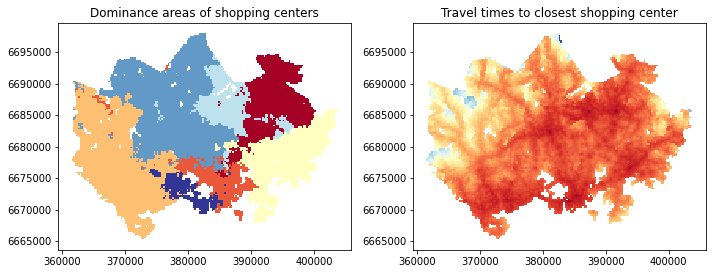

In [11]:
titles = ["Dominance areas of shopping centers", "Travel times to closest shopping center"]
cols = ["dominant_service", "min_t"]

# Plot classified travel time to Itis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot travel time by each travel method
for i in range(2):
    grid.plot(ax=axes[i], column=cols[i], cmap="RdYlBu", linewidth=0)
    axes[i].set_title(titles[i])
    axes[i].ticklabel_format(useOffset=False, style='plain')

plt.tight_layout()

That's it! If you want more challenge, you can still continue to optional problem 3. For problem 3, you need to save the `grid` with information about dominant services to file:

In [12]:
# Save grid to file (if you want to continue to problem 3)
out_fp = "grid.shp"
grid.to_file(out_fp)

/var/folders/6y/8tyffygj5nd1h5xxqrc4f7tc0000gp/T/ipykernel_89281/100901066.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid.to_file(out_fp)
